In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import json
import math
from random import sample, shuffle
import matplotlib.pyplot as plt
from sklearn import preprocessing
import keras
from keras import layers
import tensorflow as tf
import statistics

# **Dataset description**

This project uses the [UC Berkeley-Biosense Synchronized Brainwave Dataset](https://www.kaggle.com/datasets/berkeley-biosense/synchronized-brainwave-dataset/data) (downloaded from Kaggle).

According to the dataset description, the EEG signals were recorded using the consumer-grade Mindwave Mobile brainwave-sensing headset. This device has a single EEG electrode, located on a sensor arm, whichs rests on the forehead above the eye (FP1 position) (see technical specs of MindWave Mobile 2).

Each row entry contains a data packet generated during 1 second of recording for the respective subject, whose ID is given in column 'id'.

The stimulus the subject was represented with during the corresponding time frame is given in column 'label'.

There are 30 subjects in total. 15 were presented with a video containing the exact same sequence of stimuli, and the remaining 15 saw a video showing a slightly different sequence.

[stimulus for group 1](https://www.youtube.com/watch?v=zkGoPdpRvaU)

[stimulus for group 2](https://www.youtube.com/watch?v=sxqlOoBBjvc)

For each window (data packet), the dataset contains both the raw EEG signal sampled at 512 Hz, and the EEG power values for 8 frequency bands.

# **Load data and do some clean-up**

In [ ]:
data_path = '/content/drive/My Drive/eeg-data.csv'
eeg = pd.read_csv(data_path)

#remove unlabeled samples
eeg = eeg.loc[~eeg["label"].isin(["unlabeled", "everyone paired"])]

#remove column "Unnamed: 0" and reset dataframe index
eeg.drop(["Unnamed: 0"], axis=1, inplace=True)
eeg.reset_index(drop=True, inplace=True)

#drop samples with poor signal quality (0 is optimal)
eeg = eeg.loc[eeg["signal_quality"] < 50]

#the dataset contains quite a few duplicates (see EEG_data_inspection.ipynb)
#those need to be removed to avoid data leakage during train-test-splits
eeg = eeg.drop_duplicates(subset=['id', 'raw_values', 'label'])

print('number of useable samples: ', len(eeg))

## convert raw EEG values
eeg["raw_values"] = eeg["raw_values"].apply(lambda raw_value: json.loads(raw_value))

number of useable samples:  9554


## classes

The dataset contains 67 different labels which relate to 9 types of stimuli (see notebook *EEG_data_inspection.ipynb*):

*'Instruction', 'blink', 'colorRound', 'math', 'music', 'readyRound', 'relax', 'thinkOfItems', & 'video'*

In [ ]:
eeg['label'] = eeg['label'].str.replace('\d(-\d)?|-ver|.*(?=Instruction)', '',
                                        regex=True)
label_names = np.unique(eeg['label'])
print('classes:')
print(sorted(label_names))
num_classes = len(eeg["label"].unique())
print('num_classes: ', num_classes)

classes:
['Instruction', 'blink', 'colorRound', 'math', 'music', 'readyRound', 'relax', 'thinkOfItems', 'video']
num_classes:  9


We focus on the 'colorRound' task because it is the class with the most samples per subject. We randomly pick a pair of subjects whose EEG signals recorded during that task the classifier will learn to distinguish:

In [ ]:
#randomly pick 2 subjects
id_list = range(1, 31)
selected_subjects = sample(id_list, 2)
print("selected subjects: ", selected_subjects)

#extract all 'colorRound' samples belonging to selected subjects
eeg = eeg.loc[(eeg["label"].isin(['colorRound'])) & (eeg['id'].isin(selected_subjects))]

names, counts = np.unique(eeg['id'], return_counts=True)
label_counts = dict(zip(names, counts))
print('Number of samples per subject: ')
print(f'subject {list(label_counts.keys())[0]}: ', label_counts[list(label_counts.keys())[0]])
print(f'subject {list(label_counts.keys())[1]}: ', label_counts[list(label_counts.keys())[1]])

selected subjects:  [1, 14]
Number of samples per subject: 
subject 1:  79
subject 14:  78


Even for this task we only have 78 and 79 samples per subject, respectively. So we absolutely need to perform data augmentation to get more training samples. Since the tiny imbalance between the classes will be somewhat exacerbated by our data augmentation method, we'll use class weights during training. Helper function to generate weights:

In [ ]:
def generate_class_weights(y_train):

    '''
    Generate dict of class weights where the
    weight for a given class is the inverse of
    its proportion to the power of 5.

    '''
    frequency_dict = {}

    for l in y_train:
        if int(l) in frequency_dict.keys():
            frequency_dict[int(l)] += 1
        else:
            frequency_dict[int(l)] = 1

    nb_samples = sum(frequency_dict.values())
    class_weights = {c: (1 - (f/nb_samples))**5 for c, f in frequency_dict.items()}
    return class_weights

# **data augmentation**

The approach used here is inspired by/loosely based on the cropping training method proposed by [Schirrmeister et al. (2017)](https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.23730).

For a single subject, all (chronologically ordered) samples are concatenated to restore the original sequence of EEG values recorded during stimuli presentation. New samples are then generated by sliding a "cutter" across the length of this sequence such that the start and end of each sample *i+1* are shited by `offset` ms in relation to sample *i*. It was found that 375 was the optimal number for `offset`, providing the best tradeoff between achieved increase of dataset size and sample variability.

Before data augmentation, the data must be split into a train and test set. We need a split method which preserves the original order of the samples - concatenating samples which did not directly follow each other during data recording, and then cropping, would create artificial samples that don't represent naturally occuring EEG patterns. We therefore define a custom train-test-split function. Instead of randomly selecting samples to be put in the train or test set, it takes test samples either from the end of the sequence of samples belonging to a subject ("tail split"), or from the start of it ("head split").  

In [ ]:
def custom_train_test_split(
    X_subj, y_subj,
    test_data_position='tail',
    test_size=0.2,
    labels=[0, 1]
):

    '''
    Makes train-test-split. For each label, samples are taken either
    from the tail end of the sequence of samples with that
    label (test_data_position='tail'), or from the start of that
    sequence (test_data_position='head').
    '''
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    for l in labels:
        x_label = X_subj[y_subj == l]
        y_label = y_subj[y_subj == l]
        cutoff = int(test_size * x_label.shape[0])

        if test_data_position == 'tail':
            x_train_label = x_label[:-cutoff]
            y_train_label = y_label[:-cutoff]
            x_test_label = x_label[-cutoff:]
            y_test_label = y_label[-cutoff:]

        elif test_data_position == 'head':
            x_train_label = x_label[cutoff:]
            y_train_label = y_label[cutoff:]
            x_test_label = x_label[:cutoff]
            y_test_label = y_label[:cutoff]

        else:
            exc = f"Unknown test_data_position {test_data_position}"
            raise Exception(exc)

        x_train.extend(x_train_label)
        x_test.extend(x_test_label)
        y_train.extend(y_train_label)
        y_test.extend(y_test_label)

    return np.array(x_train), np.array(x_test), \
           np.array(y_train), np.array(y_test)

In [ ]:
class SampleCutter():
    def __init__(self, class_samples, class_labels, offset_ms=375): #375! #500
        self.class_samples = class_samples
        self.class_label = class_labels[0]
        self.nb_org_samples = len(class_samples)
        self.offset_ms = offset_ms
        self.offset_values = int(512 * (offset_ms/1000))

    def chop(self):

        '''
        generate new samples by "sliding" a cutter
        across whole length of concatenated sample sequence
        '''
        conc_samples = np.concatenate(self.class_samples, axis=0)
        cropped_samples = []
        cuts = []
        start_position = 0
        end_position = 0
        while end_position < (len(conc_samples) - 1):
            cut_here = start_position + 512
            this_sample = conc_samples[start_position:cut_here]
            if this_sample.shape[0] == 512:
                cuts.append((start_position, cut_here))
                cropped_samples.append(this_sample)
            start_position+= self.offset_values
            end_position = cut_here
        #create label list for new samples
        class_labels = [self.class_label] * len(cropped_samples)
        return cropped_samples, class_labels, cuts


def augment_training_data(
    X,
    y,
    classes=[0, 1]
):
    new_samples = []
    new_labels = []
    for c in classes:
        class_data = X[y == c]
        class_labels= y[y == c]
        cutter = SampleCutter(class_data, class_labels)
        new_class_samples, new_class_labels, class_cuts = cutter.chop()
        new_samples.extend(new_class_samples)
        new_labels.extend(new_class_labels)
        #add original samples
        new_samples.extend(class_data[1:]) #drop sample 0 as it's identical to
        new_labels.extend(class_labels[1:]) #the one produced by 1st cut

    #shuffle
    data_tuples = list(zip(new_samples, new_labels))
    shuffle(data_tuples)
    data, labels = zip(*data_tuples)

    return np.array(data), np.array(labels)

### plot example

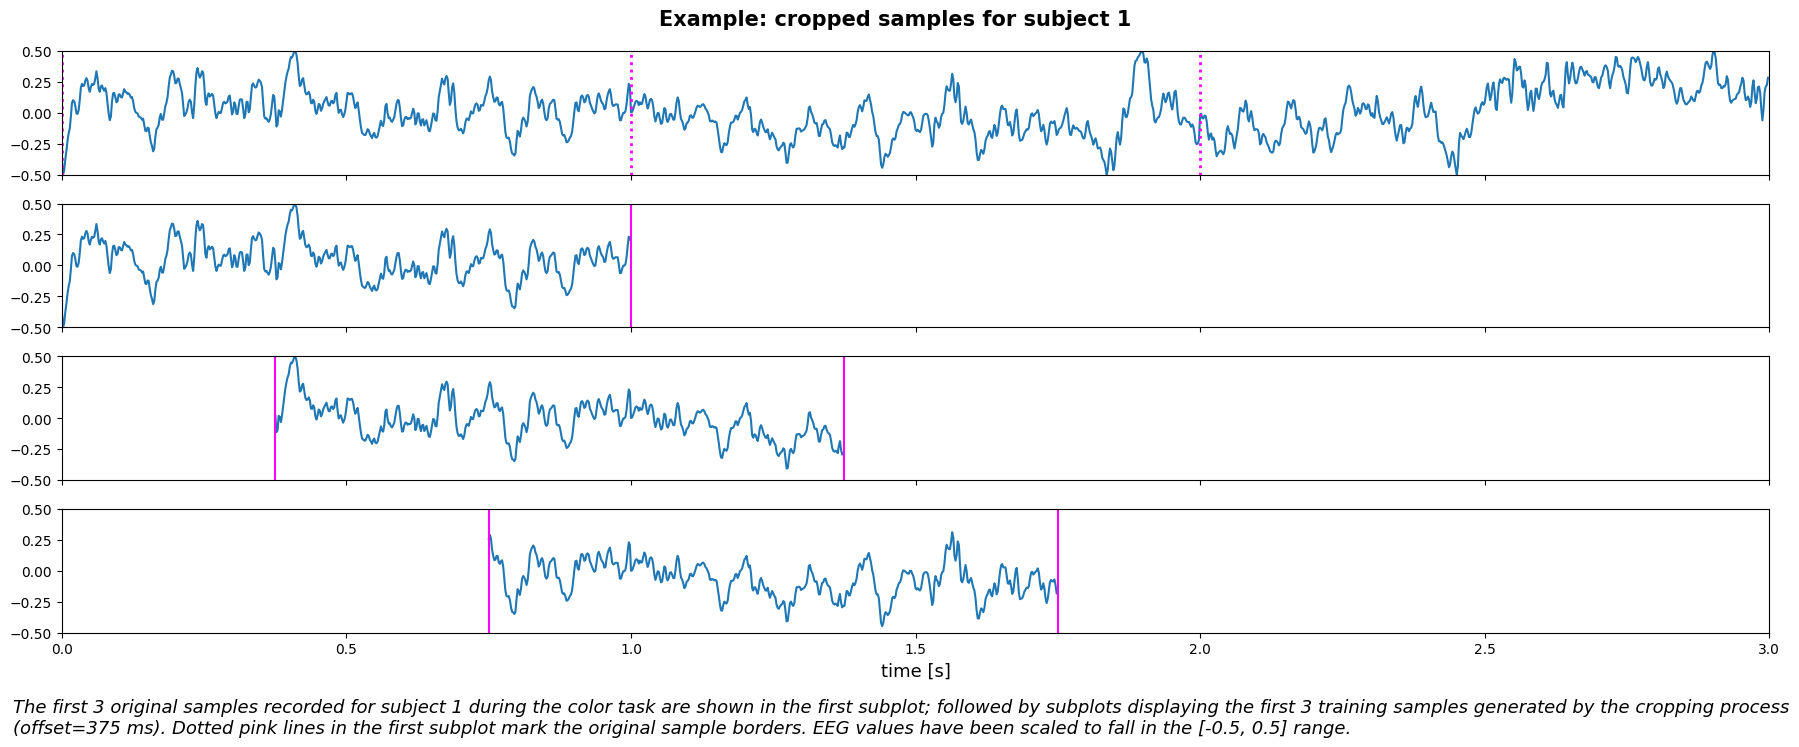

In [ ]:
#get example data and scale values
subj_id = selected_subjects[0]
plot_eeg_ = eeg.loc[eeg['id'] == subj_id][0:3]
plot_eeg = plot_eeg_.copy(deep=True)
sample_scaler = preprocessing.MinMaxScaler(feature_range=(-0.5, 0.5))
plot_values = [
    sample_scaler.fit_transform(np.asarray(i).reshape(-1, 1)) for i in plot_eeg["raw_values"]
]

#encode labels
plot_label_encoder = preprocessing.LabelEncoder()
plot_label_encoder.fit(plot_eeg['id'])
plot_eeg['id'] = plot_label_encoder.transform(plot_eeg['id'])
plot_labels = list(plot_eeg['id'])

#reshape
X_plot = np.asarray(plot_values).astype(np.float32).reshape(-1, 512, 1)
y_plot = np.asarray(plot_labels).astype(np.float32)

#crop
cutter = SampleCutter(X_plot, y_plot)
offset = cutter.offset_ms
ex_samples_, ex_labels_, ex_cuts_ = cutter.chop()

#select first 3
display_samples = ex_samples_[0:3]
display_cuts = ex_cuts_[0:3]

#concatenate all original blink samples
complete_blink_sequence = np.concatenate(plot_values)

t = np.linspace(0, len(plot_eeg), len(plot_eeg) * 512, False)
ylims_tuple = (-0.5, 0.5) #(-500, 1000)
fig, axes = plt.subplots(4, 1, figsize=(18, 7), sharex=True)

#plot complete blink sequence (concatenated samples)
axes[0].plot(t, complete_blink_sequence)
plt.setp(axes[0], ylim=ylims_tuple)
#add vertical lines to mark borders of original samples
axes[0].vlines(list(range(len(plot_eeg))), ymin=ylims_tuple[0],
               ymax=ylims_tuple[1], colors='magenta', linestyles='dotted',
               linewidth=2.)

#plot first 3 cropped samples
axes_ = axes[1:]
for idx, ax in enumerate(axes_):
    ax.plot(t[display_cuts[idx][0]:display_cuts[idx][1]], display_samples[idx])
    plt.setp(ax, ylim=ylims_tuple)
    #plot vertical lines at start/end of sample
    ax.plot((t[display_cuts[idx][0]], t[display_cuts[idx][0]]), ylims_tuple,
            scaley = False, color='magenta')
    ax.plot((t[display_cuts[idx][1]], t[display_cuts[idx][1]]), ylims_tuple,
            scaley = False, color='magenta')

axes[-1].set_xlabel("time [s]", fontdict={'size': 13})
plt.xlim(xmin=0.0, xmax=len(plot_eeg))
fig.suptitle(f'Example: cropped samples for subject {subj_id}',
             fontsize=15, fontweight='bold')
plt.tight_layout()

caption=f'The first 3 original samples recorded for subject {subj_id} during the color task are shown in the first subplot;'\
         ' followed by subplots displaying the first 3 training samples generated' \
         f' by the cropping process (offset={offset} ms).' \
         ' Dotted pink lines in the first subplot mark the original sample borders.' \
         ' EEG values have been scaled to fall in the [-0.5, 0.5] range.'
plt.figtext(0.01, -0.05, caption, horizontalalignment='left', wrap=True,
            fontsize=13, fontdict={'fontstyle': 'oblique'})

plt.show()

Since the number of samples per class/subject is still limited following this procedure, we also create a copy of each sample by concatenating the training dataset with itself (see below). Although this doesn't add any new information to the training data, it could still help the model learn somewhat better as the data are shuffled during training.

# **Model**

The general idea was to use a convolutional neural network with sigmoid activation in the output layer for binary classification. It was found that the following archictecture yielded the best results:

Four convolutional blocks consisting of two Conv1D layers each with a residual connection, where the second layer in the block has twice the number of filters as the first one. Those convolutional blocks are followed by two blocks of densely connected layers, both of which consist of two dense layers. It was found that using residual connections not just in the convolutional blocks but also between the dense layers had a stabilizing effect on model performance.

Relu activation is used both in the convolutional blocks and the dense layers.

### **Custom Keras Layer for Convolutional Blocks**



In [ ]:
class ConvBlock(layers.Layer):

    """Convolutional block consisting of two Conv1D layers
    followed by ResNet-style shortcut that allows for
    residual connection between the layer inputs and
    the output of the second Conv1D layer
    """

    def __init__(self, filters_layer1, kernel_size, pool=False, **kwargs):

        super().__init__(**kwargs)
        self.filters_layer1 = filters_layer1
        self.filters_layer2 = self.filters_layer1 * 2
        self.kernel_size = kernel_size
        self.pool = pool

    def build(self, input_shape):
        self.convolution1 = layers.Conv1D(filters=self.filters_layer1,
                                          kernel_size=self.kernel_size, #1
                                          strides=2,
                                          activation="relu",
                                          kernel_initializer=keras.initializers.HeNormal(),
                                          kernel_regularizer=keras.regularizers.L1L2(),
                                          padding="same")
        self.convolution2 = layers.Conv1D(filters=self.filters_layer1 * 2,
                                          kernel_size=self.kernel_size,
                                          strides=1,
                                          activation="relu",
                                          kernel_initializer=keras.initializers.HeNormal(),
                                          kernel_regularizer=keras.regularizers.L1L2(),
                                          padding="same")
        self.shortcut = layers.Conv1D(filters=self.filters_layer1 * 2,
                                      kernel_size=1,
                                      strides=2,
                                      activation="relu",
                                      kernel_initializer=keras.initializers.HeNormal(),
                                      kernel_regularizer=keras.regularizers.L1L2(),
                                      padding="same")

        self.addition = layers.Add()
        self.normalization = layers.BatchNormalization()
        if self.pool:
            self.pooling = layers.AveragePooling1D(2)


    def call(self, inputs):
        convolved1 = self.convolution1(inputs)
        convolved2 = self.convolution2(convolved1)
        shortcut = self.shortcut(inputs)
        added = self.addition([shortcut, convolved2])
        output = self.normalization(added)
        if self.pool:
            output = self.pooling(output)

        return output


    def get_config(self):
        config = super().get_config()
        config.update({"filters_layer1": self.filters_layer1,
                       "filters_layer2": self.filters_layer2,
                       "kernel_size": self.kernel_size,
                       "pool": self.pool})

        return config

### **"Tribrid" Architecture**

During extensive experimentation, it was found that architectures with larger kernel sizes in the final convolutional layers seemed more powerful but had extremely high variance, producing promising results in some training runs and abysmal results in others, without any changes to the model configuration or training data. Furthermore, for larger kernel sizes, the number of epochs required for the model to convergence was wildly different between training runs.

Therefore, a "tribrid" model is trained which allows for a low-level representation of the input to flow through 3 different "processing paths". Each of those paths consists of the same number of convolutional blocks, followed by two blocks of densely connected layers with 128 and 64 nodes, respectively. However, the layers in each convolutional block have different kernel sizes between the paths.

This is somewhat similar to a vertical ensemble of classifiers. However, instead of training independent models, all paths are optimized in the same training run. Before the paths are merged for the final prediction, additive self-attention is applied to allow for an exchange of information between them. The idea is for the paths to "collaborate" by focusing on different features in the input, but taking into account other representations of the data before the final prediction.

In [ ]:
def build_path(
    shared_layer_output,
    filters=[24, 96, 384],
    kernel_sizes=[5, 8, 13]
    ):

    conv2 = ConvBlock(filters_layer1=filters[0], kernel_size=kernel_sizes[0])(shared_layer_output)
    conv3 = ConvBlock(filters_layer1=filters[1], kernel_size=kernel_sizes[1])(conv2)
    conv4 = ConvBlock(filters_layer1=filters[2], kernel_size=kernel_sizes[2])(conv3)
    conv4_drop = layers.Dropout(0.3)(conv4)

    flat = layers.Flatten()(conv4_drop)
    dense = layers.Dense(128, activation="relu", kernel_initializer=keras.initializers.HeNormal(), #56
                         kernel_regularizer=keras.regularizers.L2())(flat)
    dense2 = layers.Dense(128, activation="relu", kernel_initializer=keras.initializers.HeNormal(), #56
                          kernel_regularizer=keras.regularizers.L2())(dense)
    dense_skip = layers.Add()([dense, dense2])
    drop_dense2 = layers.Dropout(0.5)(dense_skip) #0.4

    dense3 = layers.Dense(64, activation="relu", kernel_initializer=keras.initializers.HeNormal(), #28
                          kernel_regularizer=keras.regularizers.L2())(drop_dense2)
    dense4 = layers.Dense(64, activation="relu", kernel_initializer=keras.initializers.HeNormal(), #28
                          kernel_regularizer=keras.regularizers.L2())(dense3)
    dense_skip2 = layers.Add()([dense3, dense4])
    drop_dense3 = layers.Dropout(0.2)(dense_skip2)

    return drop_dense3

def create_model():
    #1st convolutional block is shared between paths so all learn the same low-level features
    model_input = layers.Input(shape=(512, 1)) #512
    conv1 = ConvBlock(filters_layer1=6, kernel_size=3, name="shared_convolutional_block")(model_input)

    #low-level features extracted by 1st convolutional block flow through 3 different paths
    #with slightly different number of filters and different kernel sizes in the convolutional blocks
    path1_output = build_path(conv1, filters=[56, 96, 148], kernel_sizes=[9, 15, 21])
    path1_output = layers.Reshape((1, 64))(path1_output)

    path2_output = build_path(conv1, filters=[24, 96, 148], kernel_sizes=[5, 7, 9])
    path2_output = layers.Reshape((1, 64))(path2_output)

    path3_output = build_path(conv1, filters=[56, 96, 148], kernel_sizes=[9, 16, 24])
    path3_output = layers.Reshape((1, 64))(path3_output)

    #concatenate outputs from path 1, 2, & 3
    concatenated_outputs = layers.Concatenate(axis=1)([path1_output, path2_output, path3_output])

    #apply self attention such that representations of each path "take into account" the other paths' outputs
    ensemble_attention = layers.AdditiveAttention()
    ensemble_attention_output = ensemble_attention([concatenated_outputs,
                                                    concatenated_outputs,
                                                    concatenated_outputs],
                                                    training=True)
    ensemble_attention_norm = layers.LayerNormalization()(concatenated_outputs + ensemble_attention_output)

    #after applying attention, merge paths by summing up outputs
    merged_paths = keras.ops.sum(ensemble_attention_norm, axis=1)
    model_output = layers.Dense(1, activation="sigmoid")(merged_paths)

    model = keras.Model(inputs=model_input, outputs=model_output)

    return model

# **train example model for selected pair of subjects**

#### prepare subject data and labels

In [ ]:
#encode labels
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(eeg['id'])
eeg['id'] = label_encoder.transform(eeg['id'])
labels_list = list(eeg["id"])

### scale data
scaler = preprocessing.MinMaxScaler(feature_range=(-0.5, 0.5))
values_list = [
    scaler.fit_transform(np.asarray(i).reshape(-1, 1)) for i in eeg["raw_values"]
]

# reshape
X = np.asarray(values_list).astype(np.float32).reshape(-1, 512, 1)
y = np.asarray(labels_list).astype(np.float32)

#### train-test-split
x_train_unaug, x_test, y_train_unaug, y_test = custom_train_test_split(
    X,
    y,
    test_data_position="tail",
    test_size=0.25
)

print("x_train_unaug.shape: ", x_train_unaug.shape)

#### Perform data augmentation on training data
x_train, y_train = augment_training_data(
    x_train_unaug,
    y_train_unaug
)

print("x_train.shape after augmentation: ", x_train.shape)

#class weights
class_weights = generate_class_weights(y_train)

#copy samples
x_train = np.concatenate([x_train] * 2)
y_train = np.concatenate([y_train] * 2)

print("x_train.shape after copying samples: ", x_train.shape)

#prepare datasets
batch_size = 64
buffer_size = batch_size * 5
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
train_dataset = train_dataset.shuffle(buffer_size, reshuffle_each_iteration=True).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

x_train_unaug.shape:  (119, 512, 1)
x_train.shape after augmentation:  (430, 512, 1)
x_train.shape after copying samples:  (860, 512, 1)


#### create model

In [ ]:
example_model = create_model()
example_model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 512, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ shared_convolutional_blo… │ (None, 256, 12)        │            324 │ input_layer_12[0][0]   │
│ (ConvBlock)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_block_108            │ (None, 128, 112)       │         64,568 │ shared_convolutional_… │
│ (ConvBlock)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_block_111            │ (None, 128, 48)        │          8,088 │ shared_convolutional_… │
│ (ConvBlock)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_block_114            │ (None, 128, 112)       │         64,568 │ shared_convolutional_… │
│ (ConvBlock)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_block_109            │ (None, 64, 192)        │        460,512 │ conv_block_108[0][0]   │
│ (ConvBlock)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_block_112            │ (None, 64, 192)        │        171,744 │ conv_block_111[0][0]   │
│ (ConvBlock)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_block_115            │ (None, 64, 192)        │        489,696 │ conv_block_114[0][0]   │
│ (ConvBlock)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_block_110            │ (None, 32, 296)        │      1,575,460 │ conv_block_109[0][0]   │
│ (ConvBlock)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_block_113            │ (None, 32, 296)        │        708,772 │ conv_block_112[0][0]   │
│ (ConvBlock)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_block_116            │ (None, 32, 296)        │      1,792,132 │ conv_block_115[0][0]   │
│ (ConvBlock)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_108 (Dropout)     │ (None, 32, 296)        │              0 │ conv_block_110[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_111 (Dropout)     │ (None, 32, 296)        │              0 │ conv_block_113[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_114 (Dropout)     │ (None, 32, 296)        │              0 │ conv_block_116[0][0]   │
├──────────────────────

 Total params: 9,060,537 (34.56 MB)

 Trainable params: 9,057,041 (34.55 MB)

 Non-trainable params: 3,496 (13.66 KB)

In [ ]:
#keras.utils.plot_model(example_model, dpi=53, to_file="/content/drive/My Drive/eeg_model.png")

#### define metrics, optimizer, loss, callbacks, and train model

In [ ]:
#define optimizer, loss, callbacks
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.BinaryCrossentropy()

#define metrics
binary_accuracy = keras.metrics.BinaryAccuracy(name='binary_accuracy')
precision =  keras.metrics.Precision(name='precision')
recall = keras.metrics.Recall(name='recall')

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_binary_accuracy",
        factor=0.1,
        patience=2,
        min_lr=0.000001
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        start_from_epoch=15,
        restore_best_weights=True
    )
]

# compile and fit model
example_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[binary_accuracy, precision, recall]
)

example_model.fit(
    train_dataset,
    epochs=60,
    validation_data=test_dataset,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - binary_accuracy: 0.5633 - loss: 20.6492 - precision: 0.5677 - recall: 0.5767 - val_binary_accuracy: 0.6053 - val_loss: 15.6398 - val_precision: 0.5769 - val_recall: 0.7895 - learning_rate: 0.0010
Epoch 2/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - binary_accuracy: 0.7772 - loss: 13.7374 - precision: 0.7779 - recall: 0.7792 - val_binary_accuracy: 0.6053 - val_loss: 12.8427 - val_precision: 1.0000 - val_recall: 0.2105 - learning_rate: 0.0010
Epoch 3/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - binary_accuracy: 0.8488 - loss: 10.6467 - precision: 0.8412 - recall: 0.8691 - val_binary_accuracy: 0.5526 - val_loss: 10.7231 - val_precision: 0.5333 - val_recall: 0.8421 - learning_rate: 0.0010
Epoch 4/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - binary_accuracy: 0.8971 - loss: 9.1980 - precision: 0.8886 - recall: 0.9022 - val_binary_accuracy: 0.5263 - val_loss: 11.2643 - val_precision: 0.5143 - val_recall: 0.9474 - learning_rate: 1.0000e-04
Ep

--> For this pair of subjects, the model reaches a maximum accuracy, precision and recall on the validation data of 0.8421.





# **"Cross validation light" for selected subject pairings**

Due to the data augmentation technique used, classic cross validation with random train-test-splits doesn't work here. We need to make sure that we create our additional training samples from a sequence of samples that did appear in that order in the original dataset.

What we do instead of random splits is creating 2 different folds per subject pairing by first doing a "tail" train-test-split and then a "head"-split. We then train a model on each of those folds.

We do this for a few randomly selected pairs of subjects, using the model architecture described above.

The model is trained for a maximum of 80 epochs with a batch size of 64, using binary crossentropy loss and the Adam optimizer with an initial learning rate of 0.001. The learning rate is reduced during training when validation accuracy fails to improve for two consecutive epochs, down to a minimum value of 1e-06.

Binary accuracy, precision and recall are calculated and displayed for each fold separately, and then averaged over both folds for each subject.

#### function to prepare data

In [ ]:
def prepare_data():
    #load dataset
    data_path = '/content/drive/My Drive/eeg-data.csv'
    eeg = pd.read_csv(data_path)

    #remove unlabeled samples
    eeg = eeg.loc[~eeg["label"].isin(["unlabeled", "everyone paired"])]
    eeg = eeg.copy(deep=True)

    #remove column "Unnamed: 0" and reset dataframe index
    eeg.drop(["Unnamed: 0"], axis=1, inplace=True)
    eeg.reset_index(drop=True, inplace=True)

    #drop samples with poor signal quality (0 is optimal)
    eeg = eeg.loc[eeg["signal_quality"] < 50]

    #remove duplicates
    eeg = eeg.drop_duplicates(subset=['id', 'raw_values', 'label'])

    #convert EEG values to lists
    eeg["raw_values"] = eeg["raw_values"].apply(lambda rv: json.loads(rv))

    #consolidate class labels
    eeg['label'] = eeg['label'].str.replace('\d(-\d)?|-ver|.*(?=Instruction)',
                                            '',
                                            regex=True)
    return eeg

def prepare_pairing(eeg_data, selected_subjects, split_type):

    eeg = eeg_data.loc[(eeg_data["label"].isin(['colorRound'])) & \
                       (eeg_data['id'].isin(selected_subjects))]
    eeg = eeg.copy(deep=True)
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(eeg['id'])
    eeg['id'] = label_encoder.transform(eeg['id'])
    labels_list = list(eeg["id"])

    scaler = preprocessing.MinMaxScaler(feature_range=(-0.5, 0.5))
    values_list = [
        scaler.fit_transform(np.asarray(i).reshape(-1, 1)) for i in eeg["raw_values"]
    ]

    X = np.asarray(values_list).astype(np.float32).reshape(-1, 512, 1)
    y = np.asarray(labels_list).astype(np.float32)

    x_train_unaug, x_test, y_train_unaug, y_test = custom_train_test_split(
        X,
        y,
        test_data_position=split_type,
        test_size=0.25
    )

    x_train, y_train = augment_training_data(
        x_train_unaug,
        y_train_unaug
    )

    class_weights = generate_class_weights(y_train)

    x_train = np.concatenate([x_train] * 2)
    y_train = np.concatenate([y_train] * 2)

    batch_size = 64
    buffer_size = batch_size * 5
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    train_dataset = train_dataset.shuffle(buffer_size, reshuffle_each_iteration=True).batch(batch_size)
    test_dataset = test_dataset.batch(batch_size)

    return train_dataset, test_dataset, class_weights

#### run cross validation for 7 randomly selected subject pairings

In [ ]:
epochs = 80
data = prepare_data()
subj_ids = np.array(eeg['id'])
id_list = range(1, 31)

#define metrics
binary_accuracy = keras.metrics.BinaryAccuracy(name='binary_accuracy')
precision =  keras.metrics.Precision(name='precision')
recall = keras.metrics.Recall(name='recall')

all_results = dict()

for pi, pairing in enumerate(range(0, 7)):
    selected_subjects = sample(id_list, 2)
    print(f"Pairing {pi + 1}. Selected subjects: ", selected_subjects)

    results = {
        'binary_accuracy': [],
        'precision': [],
        'recall': []
    }

    for fi, fold in enumerate(['tail', 'head']):
        train_dataset, test_dataset, class_weights = prepare_pairing(
            data,
            selected_subjects,
            fold
        )

        #define optimizer, loss, callbacks
        optimizer = keras.optimizers.Adam(learning_rate=0.001)
        loss = keras.losses.BinaryCrossentropy()

        callbacks = [
            keras.callbacks.ReduceLROnPlateau(
                monitor="val_binary_accuracy",
                factor=0.1,
                patience=2,
                min_lr=0.000001
            ),
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                mode='min',
                restore_best_weights=True,
                start_from_epoch=20
            )
        ]

        # compile and fit model
        model = create_model()
        model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=[binary_accuracy, precision, recall]
        )

        model.fit(
            train_dataset,
            epochs=epochs,
            validation_data=test_dataset,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=0
        )

        # evaluate model
        print(f'  results for fold {fi+1}: ')
        evaluation_results = model.evaluate(test_dataset, return_dict=True, verbose=0)
        results[f'binary_accuracy'].append(evaluation_results['binary_accuracy'])
        results[f'precision'].append(evaluation_results['precision'])
        results[f'recall'].append(evaluation_results['recall'])
        print('  accuracy: ', round(evaluation_results['binary_accuracy'], 4))
        print('  precision: ', round(evaluation_results['precision'], 4))
        print('  recall: ', round(evaluation_results['recall'], 4))
        print("\n")

    all_results[f'subj. {selected_subjects[0]} & {selected_subjects[1]}'] = results

all_avg = {s: {metric: round(float(np.mean(all_results[s][metric])), 4) for metric in all_results[s].keys()} for s in all_results}
results_overview_df = pd.DataFrame.from_dict(all_avg)
results_overview_df = results_overview_df.style.set_caption("Averaged results for subject pairings")
results_overview_df

Pairing 1. Selected subjects:  [3, 7]
  results for fold 1: 
  accuracy:  0.7222
  precision:  0.7647
  recall:  0.6842


  results for fold 2: 
  accuracy:  0.7222
  precision:  0.7368
  recall:  0.7368


Pairing 2. Selected subjects:  [1, 27]
  results for fold 1: 
  accuracy:  0.8684
  precision:  0.8182
  recall:  0.9474


  results for fold 2: 
  accuracy:  0.7895
  precision:  0.8667
  recall:  0.6842


Pairing 3. Selected subjects:  [8, 4]
  results for fold 1: 
  accuracy:  0.8421
  precision:  0.8095
  recall:  0.8947


  results for fold 2: 
  accuracy:  0.9211
  precision:  0.8636
  recall:  1.0


Pairing 4. Selected subjects:  [7, 28]
  results for fold 1: 
  accuracy:  0.8158
  precision:  0.75
  recall:  0.9474


  results for fold 2: 
  accuracy:  0.7895
  precision:  0.7619
  recall:  0.8421


Pairing 5. Selected subjects:  [7, 1]
  results for fold 1: 
  accuracy:  0.6842
  precision:  0.7692
  recall:  0.5263


  results for fold 2: 
  accuracy:  0.6842
  precision:  

,subj. 3 & 7,subj. 1 & 27,subj. 8 & 4,subj. 7 & 28,subj. 7 & 1,subj. 1 & 28,subj. 6 & 18
binary_accuracy,0.722200,0.828900,0.881600,0.802600,0.684200,0.631600,0.947400
precision,0.750800,0.842400,0.836600,0.756000,0.751300,0.625000,0.928600
recall,0.710500,0.815800,0.947400,0.894700,0.552600,0.657900,0.973700


In [ ]:
results_overview_df

,subj. 3 & 7,subj. 1 & 27,subj. 8 & 4,subj. 7 & 28,subj. 7 & 1,subj. 1 & 28,subj. 6 & 18
binary_accuracy,0.722200,0.828900,0.881600,0.802600,0.684200,0.631600,0.947400
precision,0.750800,0.842400,0.836600,0.756000,0.751300,0.625000,0.928600
recall,0.710500,0.815800,0.947400,0.894700,0.552600,0.657900,0.973700
